In [264]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

In [265]:
#pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

#dataPreprocess
import csv
import numpy as np
import os

#plottingTools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#set a random seed for generation of random number by CPU/NUMPY/GPU
myseed = 420613
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
device_count = torch.cuda.device_count()
print(f"Number of CUDA devices: {device_count}")

Number of CUDA devices: 1


# Some Utilities

In [266]:
def get_device():
    '''geting device if cuda is available'''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record,title = ''):
    '''plot learning curve of your DNN()(train&dev loss)'''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train'])//len(loss_record['dev'])]
    figure(figsize=(6,4))
    plt.plot(x_1,loss_record['train'],c = 'tab:red', label = 'train')
    plt.plot(x_2,loss_record['dev'],c = 'tab:cyan', label = 'dev')
    plt.ylim(0.0,5.)
    plt.xlabel('TrainSteps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    
def plot_pred(dv_set, model, device, lim = 35., preds = None, targets = None):
    '''plot predition of your DNN'''
    if preds is None or targets is None:
        model.eval()#set model to eval mode
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim = 0).numpy()
        targets = torch.cat(targets, dim = 0).numpy()
        
    figure(figsize=(5,5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2,lim], [-0.2, lim], c = 'b')
    plt.xlim(-0.2,lim)
    plt.ylim(-0.2,lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth with Prediction')
    plt.show()

# **Preprocess**
We have three kinds of dataset:
* `train`:for training
* `dev`:for validation
* `test`:for testing

# **Dataset**
The covid2019Dataset below dose:
*  read `csv` files
*  extract features
*  spilt `covid.train.csv` dataset into train/dev sets
*  normalize features

Finishing TODO might make you pass baseline.

**数据第0行为列名从第一行开始；第0列为ID，1到93列为特征，第94列即最后一列为标签，即positivetested_positive
    ![image.png](datasetStructure.png)**
# Feature extract
**除非数据特征特别少，否则都要进行特征选择，筛选与目标值相关性强的属性来作为神经网络的输入下面为特征选择阶段，通过f_regerssion评价特征与目标值之间的相关度得分来选择是否将某个特征作为神经网络的输入**

In [267]:
import pandas as pd 
import numpy as np

data = pd.read_csv('covid.train.csv')
x = data[data.columns[1:94]]
y = data[data.columns[94]]

# print(data.columns[1:94])

# print(y)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import preprocessing

x = (x - x.min())/(x.max() - x.min())

bestfeatures = SelectKBest(score_func=f_regression, k = 5)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
# print(dfscores)
dfcolumns = pd.DataFrame(x.columns)
# print(dfcolumns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(15,'Score'))

                 Specs          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191


In [268]:
'''
## 数据处理经验总结
* `1.`使用list来存储特征列index，使用list来存储split的行号
* `2.`在选择行和列结束之后对self.data进行赋值时候numpy转化成tensor
* `3.`对数据的标准化处理等修改数据的行为都直接对self.data进行
* `4.`不要在data转换为self.data之前对data进行修改
'''
class COVID2019Dataset(Dataset):
    '''dataset for loading and preprocessing the Covid2019Dataset'''
    def __init__(self,
             path,
             mode = 'train',
             target_only = 'False'):
        self.mode = mode
        
        #read the data into numpy arrays
        #使用with关键字使得异常处理自动进行，with经常在处理文件时使用,并且其会自动关闭文件
        with open(path,'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:,1:].astype(float)
        
        #如果不是只选择提取出来的特征，那么将所有特征作为输入。如果只需要目标特征
        #那么就只选择相关度高的特征
        if not target_only:
            feats = list(range(93))
            
        else:
            
            feats =[75,57,42,60,78,43,61,79,40,5,76,41,59,77,92]
        
        if mode == 'test':
            #testing data:894 * 93
            #93 = 40 states + 18(17+1)(day1) + 18(17+1))(day2) + 17(day3) 
            data = data[:,feats]
            self.data = torch.FloatTensor(data)
        else:
            #train data:2700 * 94
            #94 = 40 + 18 + 18 + 18
            target = data[:,-1]
            data = data[:,feats]
            
            #splitting data into train and dev dataset
            '''
            len(data) 用于获取二维数组的行数。
            len(data[0]) 用于获取二维数组的列数（假设每行都有相同数量的元素）,
            即获取data[0]中的元素个数而不是data[0]的个数,首先获取对应行数据的index
            这样也便于后续标准化的处理，将numpy转化为张量之后再进行标准化即可
            '''
            if mode == 'dev':
                indice = [i for i in range(len(data)) if i%10 == 0]
            elif mode == 'train':
                indice = [i for i in range(len(data)) if i%10 != 0]
            
            self.data = torch.FloatTensor(data[indice])
            self.target = torch.FloatTensor(target[indice])
            
        #Normalize features，try to remove this part to see what happen
        #官网解释dim参数：dim (int) – the dimension to reduce（要压缩的那个参数）
        
        '''如果只选择选定的特征则无需进行标准化，所以将其注释掉。有一些特征与标签相关度太小'''
#         mean = self.data[:, 40:].mean(dim = 0, keepdim = True)
#         std = self.data[:, 40:].std(dim = 0, keepdim = True)
#         self.data[:, 40:] = (self.data[:, 40:] - \
#         mean)\
#         /std
        
#         print('self.data[:, 40:].mean:{}'.format(mean))
#         print('self.data[:,40:].std:{}'.format(std))
        self.dim = self.data.shape[1]
        
        print('Finishing reading the {} set of Covid2019Dataset including {} samples\
        each sample with dim = {}'.format(mode,len(self.data),self.dim))
              
    def __getitem__(self,index):
        if self.mode in ['train','dev']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]
    def __len__(self):
        return len(self.data)
              
                 
              
              

## DataLoader
A `DataLoader` loads data from a given Dataset into batches.
* dataset (Dataset) – 加载数据的数据集。
* batch_size (int, optional) – 每个batch加载多少个样本(默认: 1)。
* shuffle (bool, optional) – 设置为True时会在每个epoch重新打乱数据(默认: False).
* sampler (Sampler, optional) – 定义从数据集中提取样本的策略。如果指定，则忽略shuffle参数。
* num_workers (int, optional) – 用多少个子进程加载数据。0表示数据将在主进程中加载(默认: 0)
* collate_fn (callable, optional) –是一个可调用对象，用于定义如何将一个 batch 的样本组合在一   起。通常，DataLoader 会自动将多个样本堆叠成一个批次（batch）。但在某些情况下，你可能需要自定   义这个过程，例如处理变长序列、不同形状的数据、或者执行一些特殊的预处理操作。
* pin_memory (bool, optional) – pin_memory：将数据放置在锁页内存中，以加速从 CPU 到 GPU 的   数据传输，适用于 GPU 训练时提高数据加载效率。
* drop_last (bool, optional) – 如果数据集大小不能被batch size整除，则设置为True后可删除最后   一个不完整的batch。如果设为False并且数据集的大小不能被batch size整除，则最后一个batch将更*   小。(默认: False)

In [269]:
#官网解释：数据加载器。组合数据集和采样器，并在数据集上提供单进程或多进程迭代器。
def prepDataLoader(path, mode, batch_size, n_jobs = 0, target_only = False):
    '''Generate dataset and put it into a dataloader.'''
    #使用参数初始化实现的抽象类后续需要dataset来传给Dataloader进行迭代
    dataset = COVID2019Dataset(path,mode = mode,target_only = target_only)
    dataloader = DataLoader(dataset, batch_size, 
                            shuffle=(mode == 'train'), 
                            drop_last=False,num_workers=n_jobs,
                            pin_memory= True
                           )
    return dataloader


# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [270]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        #定义神经网络，更改模型使其表现得更佳
        
        '''nn.Sequential 一个时序容器，Modules会以参数传入的顺序被添加到容器中。
        当然，也可以传入一个OrderDict'''
        self.net = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.BatchNorm1d(24),
            nn.Dropout(p=0.12),
            nn.LeakyReLU(),
            nn.Linear(24,1)
        )
    
        #Mean square error loss
        self.criterion = nn.MSELoss(reduction='mean')
    
    def forward(self, x):
        '''定义了每次执行的计算步骤，在所有的子类中都要重写这个函数'''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target, l2_lambda=0.0):
        '''Calculate loss'''
        # TODO: you may implement L1/L2 regulization here
         #计算L2正则化项
        mse_loss = self.criterion(pred,target)
        l2_reg = 0.0
        if l2_lambda > 0.0:
            for parm in self.parameters():
                l2_reg += torch.sum(parm ** 2)
        return mse_loss + l2_lambda * l2_reg
    

# Train/Dev/Test

## Training 
**训练过程的实现主要是实现训练函数，训练函数的实现都是有步骤的，首先保证参数传递上的合理性，包含**
* `训练集`
* `验证集`
* `模型`
* `超参数配置`
* `设备选择`

**实现步骤 
1.定义optimizer，使用getattr来定义optimizer更灵活  
2.初始化opoch，early_stop_cnt等  
3.完成batch主循环，提取训练集特征向量和目标值，zero_grad() optimizer，将训练集特征x传入模型（正向传播），计算模型的损失函数值反向传播计算梯度。optimizer.step()梯度下降。每一个opch完成时记录训练集上的损失函数值  
4.在epoch循环最后计算dev_set在每个opch调整之后的损失函数值（由dev函数实现dev损失函数的计算）比较当前模型在验证集上的表现决定是否保存模型。最后再所有epoch完成之后返回最小的mse以及记录的训练集和验证集上的记录即可**

In [271]:
def train(tr_set, dev_set, model, config, device):
    
    #setup optimizer
    optimizer = getattr(torch.optim,config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    
    n_epochs = config['n_epochs']
    min_mse = 1000.
    loss_record = {'train':[],'dev':[]}      #记录训练损失
    early_stop_cnt = 0                       #早停，如果连续early_stop次验证集的损失都
    epoch = 0                                #没有比之前的更小了就停止进行调整
    while(epoch < n_epochs):                  
        model.train()
        for x,y in tr_set:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            #参考优化器参数的写法将L2正则化项的参数也写到config里由config一起管理模型的超参数
            mse_loss = model.cal_loss(pred, y,config['L2_lambda'])
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())
            
        '''
        1.每一个epoch训练完成之后使用，使用验证集测试模型的性能，这一点非常重要，
        如果模型在验证集上差距过大,我们就需要及时调整模型或是超参数避免继续训练下去浪费时间
        2.将train、dev、test分离成独立模块便于在训练时进行调整
        '''
        dev_mse = dev(dev_set, model, device)
        loss_record['dev'].append(dev_mse)
        
        if(dev_mse < min_mse):
            min_mse = dev_mse
            early_stop_cnt = 0
            torch.save(model.state_dict(), config['save_path'])#保存模型
            print("Saving model in epoch = {:4d}, loss = {:4f}"
                  .format(epoch+1, dev_mse))
        else: early_stop_cnt += 1
        
        epoch+=1
        if(early_stop_cnt > config['early_stop']):
            #stop training
            break
    
    print('Finishing training after {} epochs'.format(epoch))
    return min_mse,loss_record 

# Validation

In [272]:
def dev(dev_set, model, device):
    '''
    与训练集计算损失有所区别，由于定义criterion为MSELoss时候reduction = mean
    为标准的MSE公式，是对于整个batch而言的。所以乘每个batch的大小即可
    '''
    model.eval()#set model to eval mode
    total_mse = 0
    for x,y in dev_set:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            dev_pred = model(x)
            batch_mse = model.cal_loss(dev_pred,y,config['L2_lambda'])
        total_mse += batch_mse.detach().cpu().item() * len(x)
#print('dev_set_size:{},dev_set.dataset{}'.format(len(dev_set),len(dev_set.dataset)))
#注意这里由于传入的参数是DataLoader所以不能使用len（dataLoader）来进行长度的判断，
#要使用dataloader.dataset的长度才行
    total_mse /= len(dev_set.dataset)
    return total_mse

# Testing
**测试集需要将预测的结果保存为第一列为序号第二列为标签值的csv文件再上传到kaggle进行评测**

In [273]:
def test(test_set, model, device):
    model.eval()
    preds = []
    for x in test_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds,dim = 0).numpy()
    return preds

# Setup Hypey-parameters
`config` contains hyper-parameters for training and the path to save your model
**将超参数封装成一个字典有助于管理和调整所有超参数**

In [274]:
device = get_device()
print(device)
os.makedirs('models',exist_ok = True)
target_only = True

config = {
    'n_epochs':10000,
    'batch_size':300,
#     'optimizer':'Adam',
    'optimizer':'SGD',
    'optim_hparas':{
        'lr':0.0001,
        'momentum':0.9
        #'weight_decay': 5e-4,
    },
    'early_stop':500,
    'L2_lambda':0.0005,
    'save_path':'models/model.pth'
}

cuda


In [275]:
train_set = prepDataLoader(tr_path,'train',config['batch_size'],target_only=target_only)
dev_set = prepDataLoader(tr_path,'dev', config['batch_size'], target_only=target_only)
tt_set = prepDataLoader(tt_path, 'test',config['batch_size'], target_only=target_only)

Finishing reading the train set of Covid2019Dataset including 2430 samples        each sample with dim = 15
Finishing reading the dev set of Covid2019Dataset including 270 samples        each sample with dim = 15
Finishing reading the test set of Covid2019Dataset including 893 samples        each sample with dim = 15


In [276]:
model = NeuralNet(train_set.dataset.dim).to('cuda')
print(torch.cuda.is_available())

True


In [277]:
model_loss,model_loss_record = train(train_set, dev_set, model, config, device)

Saving model in epoch =    1, loss = 277.808716
Saving model in epoch =    2, loss = 221.832642
Saving model in epoch =    3, loss = 174.187698
Saving model in epoch =    4, loss = 84.331581
Saving model in epoch =    5, loss = 77.953209
Saving model in epoch =    6, loss = 59.353355
Saving model in epoch =   10, loss = 40.960594
Saving model in epoch =   11, loss = 31.418871
Saving model in epoch =   12, loss = 29.814255
Saving model in epoch =   13, loss = 14.191922
Saving model in epoch =   14, loss = 13.552361
Saving model in epoch =   15, loss = 9.843877
Saving model in epoch =   17, loss = 8.873101
Saving model in epoch =   19, loss = 8.509237
Saving model in epoch =   20, loss = 7.938511
Saving model in epoch =   25, loss = 7.373884
Saving model in epoch =   27, loss = 7.060056
Saving model in epoch =   29, loss = 6.219430
Saving model in epoch =   31, loss = 5.108846
Saving model in epoch =   37, loss = 4.604843
Saving model in epoch =   39, loss = 4.041026
Saving model in epoc

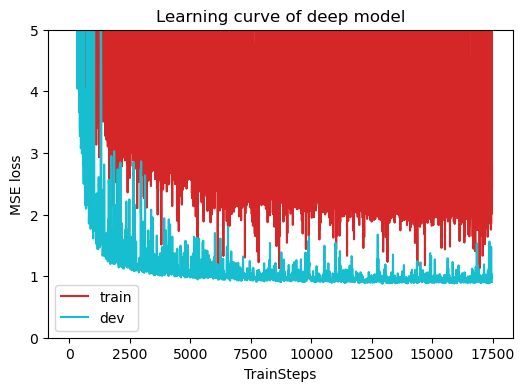

In [278]:
plot_learning_curve(model_loss_record, title='deep model')

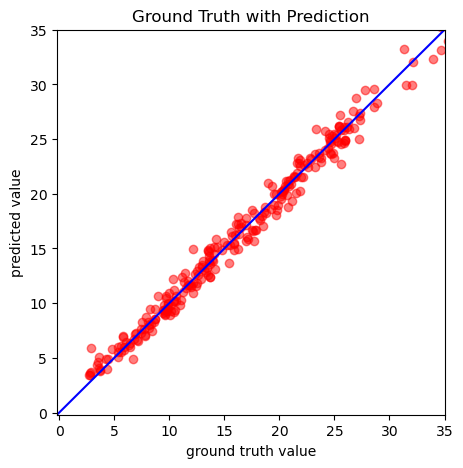

In [279]:
del model
model = NeuralNet(train_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dev_set, model, device)  # Show prediction on the validation set

In [280]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
